<h1 align="center">BDCC - Big Data Challenge</h1>

<h2 align="center">Full Dataset</h2>

<p style="text-align:center">
António Almeida, up201505836<br>
Miguel Ramalho,  up201403027<br>
Tomás Albuquerque,  up201106437
</p>

This version of the notebook contains the dataset visualization section of the original report, but is executed on the entire dataset (~36GB *uncompressed*).

The dataset was uncompressed locally and uploaded to a [Cloud Storage Bucket](https://cloud.google.com/storage/docs/json_api/v1/buckets), namely to `gs://bdcc_up201505836/EVENTS.csv`.

This time, we used a [Dask](https://distributed.dask.org/en/latest/) instance running on a cluster managed by [Google Kubernetes Engine](https://cloud.google.com/kubernetes-engine/).

### Install required libraries

In [4]:
!pip3 install matplotlib dask gcsfs seaborn distributed dask_ml dask-xgboost

### Initial Imports

In [1]:
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set()

The cluster used was comprised of 4 nodes, each with 2vCPUs and 7.5G of RAM - [n1-standard-2](https://cloud.google.com/compute/docs/machine-types). This was the best choice for our use case, given the problem at hand and the quota limitations (which we managed to increase) imposed by GCP.

In [3]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://loopy-echidna-dask-scheduler:8786 Dashboard: http://loopy-echidna-dask-scheduler:8787/status,Cluster Workers: 8 Cores: 16 Memory: 62.74 GB


### Utilities functions

In [4]:
# reads a DASK DataFrame from an EVENTS csv
def read_events(filename):
    return dd.read_csv(filename, parse_dates=['CHARTTIME', 'STORETIME'], assume_missing=True, dtype={'RESULTSTATUS': 'object',
       'STOPPED': 'object',
       'VALUE': 'object'})

# Data Visualization
This section contains some of the requested plots and some more high level information about the dataset and its contents

In [10]:
%matplotlib inline

In [5]:
#path = './EVENTS_10M.csv'
path = 'gs://bdcc_up201505836/EVENTS.csv'
df = read_events(path)
type(df)

dask.dataframe.core.DataFrame

In [60]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788.0,36.0,165660.0,241249.0,223834.0,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,15,15.00,L/min,0.0,0.0,NaN,NaN
1,789.0,36.0,165660.0,241249.0,223835.0,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,100,100.00,NaN,0.0,0.0,NaN,NaN
2,790.0,36.0,165660.0,241249.0,224328.0,2134-05-12 12:00:00,2134-05-12 12:18:00,20823.0,.37,0.37,NaN,0.0,0.0,NaN,NaN
3,791.0,36.0,165660.0,241249.0,224329.0,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,6,6.00,min,0.0,0.0,NaN,NaN
4,792.0,36.0,165660.0,241249.0,224330.0,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,2.5,2.50,NaN,0.0,0.0,NaN,NaN


In [9]:
df.compute().describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CGID,VALUE,VALUENUM,WARNING,ERROR,RESULTSTATUS,STOPPED
count,9.999990e+05,999999.000000,999999.000000,999542.000000,999999.000000,847390.000000,999999.000000,999999.000000,999999.000000,999999.000000,0.0,0.0
mean,5.003201e+05,5800.489858,148498.552431,254446.497683,222180.309609,18182.896204,85.618958,85.618958,0.065634,0.001921,NaN,NaN
std,2.892129e+05,3503.306794,27689.259457,31045.418397,2488.229065,2288.817959,778.306520,778.306520,0.247641,0.043787,NaN,NaN
min,1.000000e+00,23.000000,100009.000000,200203.000000,220045.000000,14023.000000,-610.000000,-610.000000,0.000000,0.000000,NaN,NaN
25%,2.500005e+05,2636.000000,128932.000000,225777.000000,220180.000000,16037.000000,17.000000,17.000000,0.000000,0.000000,NaN,NaN
50%,5.000000e+05,5885.000000,142471.000000,256064.000000,220277.000000,18462.000000,56.000000,56.000000,0.000000,0.000000,NaN,NaN
75%,7.499995e+05,8799.000000,172420.000000,284784.000000,224684.000000,20652.000000,97.000000,97.000000,0.000000,0.000000,NaN,NaN
max,1.058971e+06,10694.000000,199622.000000,299972.000000,228377.000000,21545.000000,598185.120000,598185.120000,1.000000,1.000000,NaN,NaN


### Scatter Plot of values per item
- For a given item, i.e., `ITEMID`, get its respective rows
- Plot its items, i.e., `VALUENUM` entries
- A scatter plot was used as it represents more appropriately the data presented

In [6]:
def item_hist(df, item):
    df[['ITEMID', 'CHARTTIME', 'VALUENUM']]\
        .query(f'ITEMID == {item}')\
        .compute()\
        .plot(x='CHARTTIME', y='VALUENUM', style='.', figsize=(14,7), title=f'Values for ITEMID {item}')
    
    # display options
    ax = plt.gca(); ax.set_xlabel('Time'); ax.set_ylabel('Values')

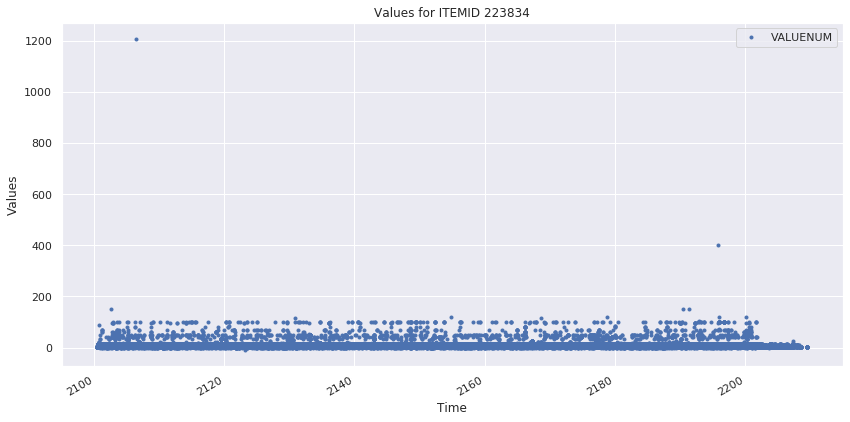

In [7]:
item_hist(df, item=223834)

### Histogram of values per patient

- For each patient, i.e., `SUBJECT_ID`, get its hospital admissions, i.e., `HADM_ID`
- For each hospital admission, plot the entries for each item, i.e., `VALUENUM` for each `ITEMID`
- A scatter plot was used as it represents more appropriately the data presented

In [8]:
# Get histogram of values per patient
def patient_hist(df, patient):
    df[['SUBJECT_ID', 'ITEMID', 'VALUENUM', 'HADM_ID']]\
                .query(f'SUBJECT_ID == {patient}')\
                .compute()\
                .groupby('HADM_ID')['ITEMID', 'VALUENUM']\
                .plot(x='ITEMID', y='VALUENUM', kind='scatter', figsize=(14,7), title="Values per patient", c="b")

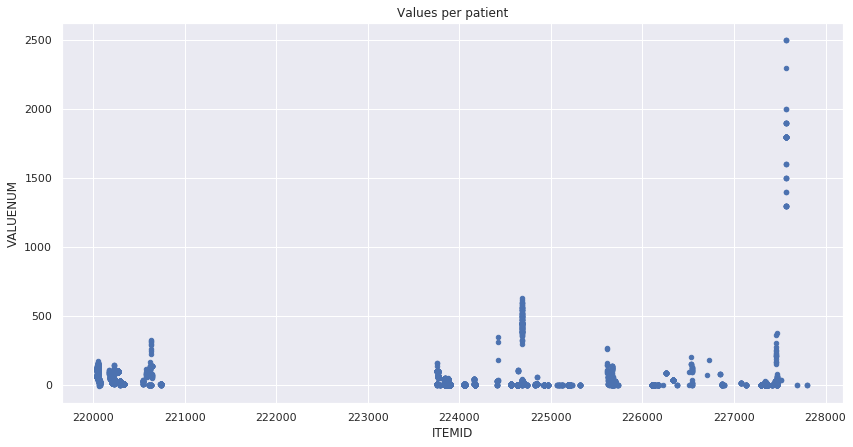

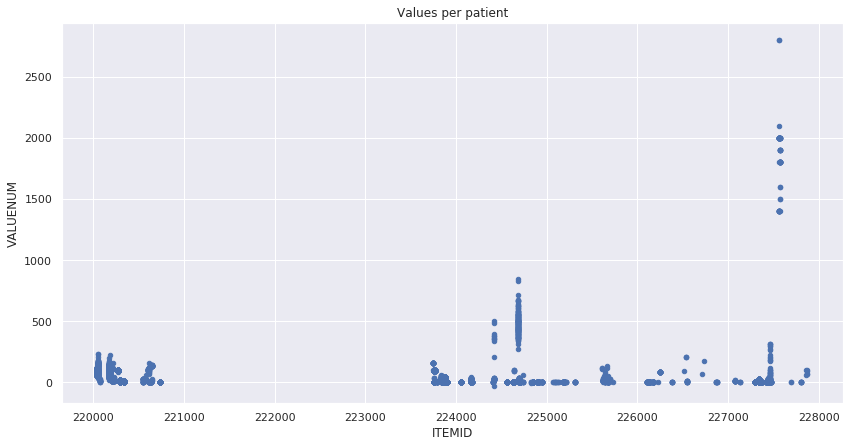

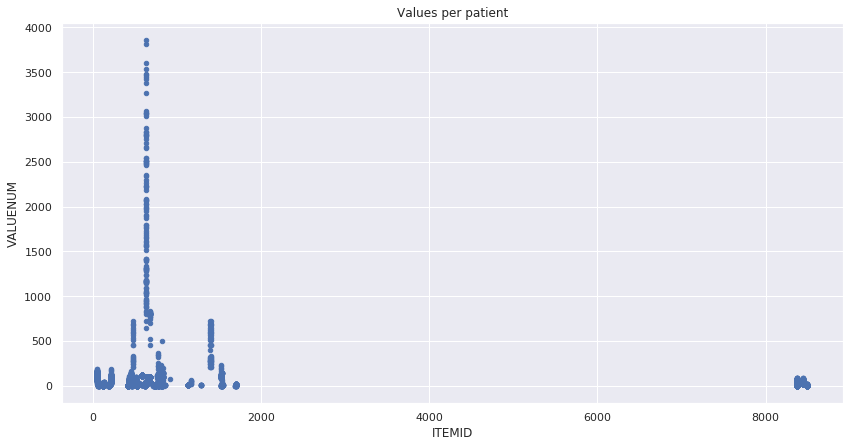

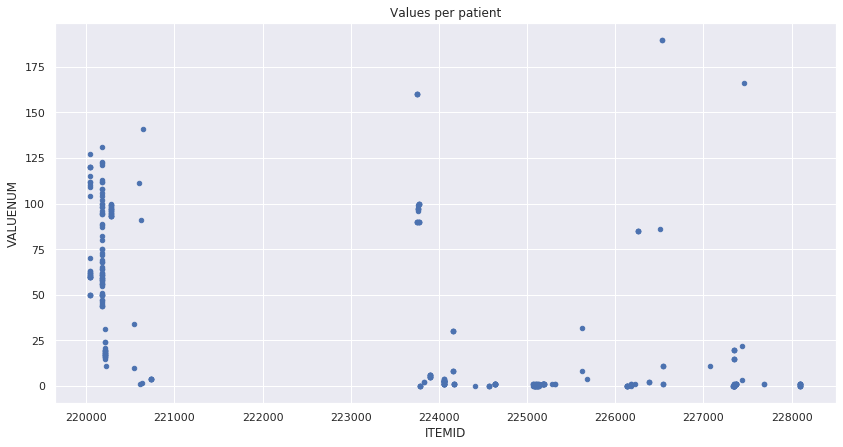

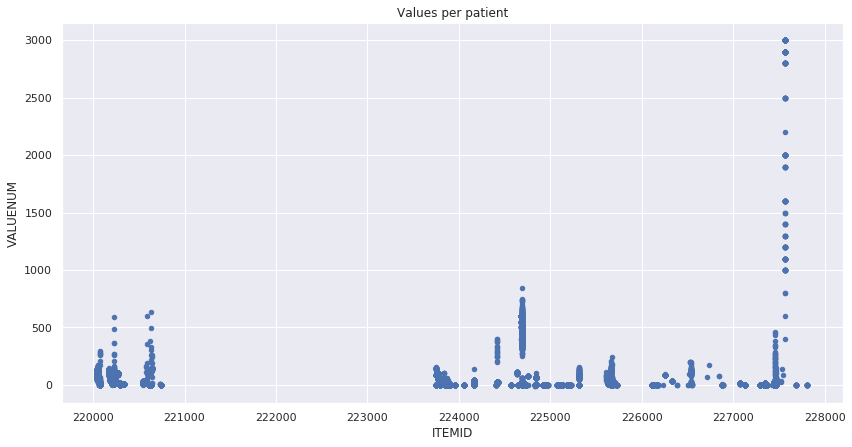

In [9]:
patient_hist(df, patient=2090)

### Histogram of frequency per item

In [19]:
# Get histogram of frequency per item
def item_hist(df):
    df[['ITEMID', 'VALUENUM']].compute().groupby('ITEMID').count().hist(figsize=(14, 7))
    
    # display options
    ax = plt.gca(); ax.set_xlabel('Items'); ax.set_ylabel('Frequency'); ax.set_title('Frequency per item')

The following call fails due to a known, yet *under-documented* [issue](https://github.com/dask/distributed/issues/1674).

In [20]:
item_hist(df)

distributed.client - WARNING - Couldn't gather 59 keys, rescheduling {"('getitem-2b1aa818345efaefa437f7ff9ab330ed', 163)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 219)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 203)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 451)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 195)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 275)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 299)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 331)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 19)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 131)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab330ed', 115)": ('tcp://10.52.4.3:44349',), "('getitem-2b1aa818345efaefa437f7ff9ab33

CommClosedError: in <closed TCP>: Stream is closed: while trying to call remote method 'gather'

### Items's values over time for a given ICU
- For a given Intensive Care Unit instance, i.e., `ICUSTAY_ID`, get its entries
- Plot its items' values, i.e., `VALUENUM` entries, over time

In [14]:
def icu_hist(df, icu):
    df_icu = df[['SUBJECT_ID', 'VALUENUM', 'ICUSTAY_ID', 'CHARTTIME', 'ITEMID']]\
                .query(f'ICUSTAY_ID == {icu}')\
                .compute()    
    sns.relplot(x="CHARTTIME", y="VALUENUM", col="ICUSTAY_ID",
                # hue="ITEMID", #style="ITEMID", # size="VALUENUM",
                kind="line", legend="full",
                height=8, aspect=2, 
                data=df_icu);

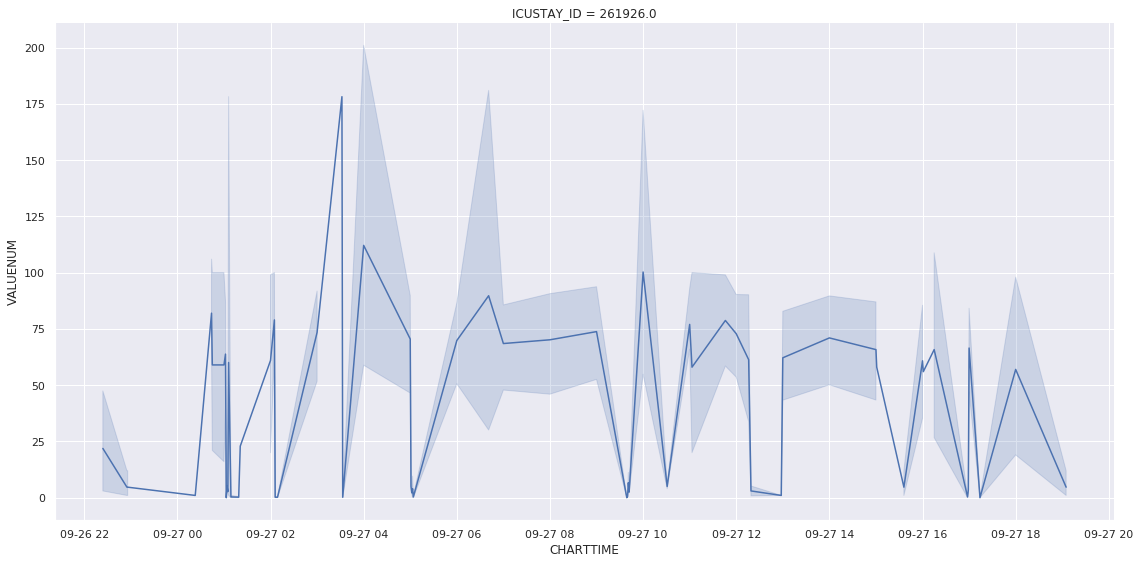

In [15]:
icu_hist(df, 261926)

# Machine Learning Task

Given the size of the dataset and the available resources, running the Machine Learning task was deemed as not viable within reasonable time - all attemps failed through inconsistencies caused by running out of memory.

However, the setup proved itself viable, and for this use case, it's simply a matter of scaling up the cluster be comprised of extra nodes and/or vCPUS/RAM. This was not possible for us given quota constraints imposed by GCP.

# General Remarks

Below are some screenshots/videos showcasing the process involved in the development of this report.

In [18]:
from IPython.display import Video

#### Visualizing Task Distribution/Execution

The runtime distribution and execution of the scheduled tasks can be **visualized and monitored** through Dask's web interface, which proved useful to debug the processing of long jobs.

In [23]:
Video('./res/tasks.m4v', width=750)

#### Monitoring Workers

Additionally, workers should also be monitored, namely to assess whether the current allocated resources are capable of handling the job's load. This helped us reaching the final form of the setup, as we were iteratively adapting the cluster's and workers' specifications to reach a *sweet spot* in terms of performance. 

In [25]:
Video('./res/workers.m4v', width=750)

## Visualizing a Task's Graph

A task's logical execution can be visualized through a generated graph, from which we can identify possible performance bottlenecks.

![a task's graph](./res/graph.png)

# Final Remarks about this notebook
This notebook focuses on distributing computation for plots and statistics, for the complete dataset. 

The [`sample.ipynb`](sample.ipynb) contains remarks from the overall project and also, the ML task code and results. 